# Промежуточное моделирование для Модели микроуровневого стресс-тестирования (на уровне отдельных компаний-застройщиков) - "Банкротства застройщиков"

<span style="font-color:blue; font-size:large"><i>Блокнот для расчет и оценки промежуточных моделей.</i></span>
    
## Алгоритм работы
 
  1. **Чтение данных из базы данных (таблицы SPARK, LOAN и BANKRP).** Данные читаются посредством запросов, созданных на этапе созднания базы данных. Первичный счет показателей осуществляется в этих запросах. При желании можно загрузить данные непосредственно из таблиц, для этого надо поменять название таблицы в строке запроса, в коде, в данном блокноте. Однако вычисления на стороне базы данных несколько быстрее, чем вычисления в коде.   
  2. **Чтение данных из "Долгосрочной модели".** Эти данные предполагается в будущем моделировать в Питоне, однако в настоящий момент они берутся из модели в файле Excel. Эти данные необходимы для построения и расчета промежуточных под-моделей, используемых в основном блоке расчета модели банкротств  
  3. **Построение и расчет промежуточных под-моделей**. Под-модели используются в качестве поставщиков данных для основной модели
  4. **Формирование входного тренда для основной модели** Результаты промежуточного моделирования сводятся в один фрейм, этот фрейм чистится и форматируется под исходный формат данных для основной модели. Подготовленный фрейм записывается в рабочую базу данных
  
<details>
  
## Структура блокнота

- Первый блок: общие константы, создание коннекта к рабочей базе банных
- Второй блок: чтение данных из Долгосрочной модели и базы данных долгосрочной модели. Данные читаются из Excel файла (прогноз) и sqlite3 файла (факт, база данных), используются в разных моделях этого блокнота. 
- Третий блок: модели ROA и Z_A
  - Чтение и подготовка данных для моделирования ROA и Z_A
  - Оценка и расчет моделей ROA и Z_A
- Четвертый блок: модель Ставки по кредитам
- Пятый блок: форматирование фрейма конечных данных для записи в рабочую базу. Фрейм создается из фрейма результатов моделировани, фактических полей базы SPARK и таблицы фактических банкротств компаний
  - Формирование структуры данных по компаниям и годам
  - Продление полей на прогнозный период
  - Заполнение пропусков, удаление "пустышек" и дублирования
  - Установка флага фактических банкротств Y (данные читаются из рабочей базы)
- Окончание: сохранение результата в рабочей базе
    
</details>

In [25]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from os import path, getcwd
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import sqlalchemy as sa
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import patsy
import datetime as dt

# общие константы и функции
idx=pd.IndexSlice # объект для индексации мультииндексного фрейма
strDB_path=path.join('..', 'DB', 'bankrp.sqlite3')
strDB_YEAR_path=path.join('..', 'DB', 'year.sqlite3')

# константы базы данных SQLite3
strNOZA_table='noza' # название таблицы NOZA в базе данных SQLite
strNOZA_agg='noza_ag' # название рабочего  представления для таблицы NOZA в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strNOZA_data_pass='noza_columns' # таблица с названиями колонок для таблицы noza
strSPARK_table='spark' # название таблицы SPARK в базе данных SQLite
strSPARK_agg='spark_ag' # название рабочего  представления для таблицы SPARK в базе данных SQLite (ROA из базы)
strSPARK_agg_roa_calc='spark_ag_roa_calc' # название рабочего  представления для таблицы SPARK (ROA считаем)
strSPARK_data_pass='spark_columns' # таблица с названиями колонок для таблицы SPARK
strLOAN_table='loan' # название таблицы LOAN в базе данных SQLite
strLOAN_data_pass='loan_columns' # таблица с названиями колонок для таблицы loan
strLOAN_agg='loan_agg' # название рабочего  представления для таблицы LOAN в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strBNKRPT_table='bankrp' # название таблицы с фактическими банкротствами
strModeLDATA_table='model_data'  # название таблицы с входными данными для основной модели "Банкротства застройщиков"

strInfoTable='update_info' # таблица с информацией об обновлении базы даных

strLEND_PRC_table='lending'
strLEND_RES_table='lending_reserv'
# ------------

# пути и константы для данных из Excel-версии модели и базы данных
strModelSource=path.join('..', 'DB', 'SRC', 'Долгосрочная модель.xlsx')
strMargaSheet='Новостройки'
strModelSheet='Модель'
strStrojKomplex='Стройкомплекс'
#---------------

strMD='''
<div class="alert alert-block alert-success">
<b>База данных - {bd_path}<br>
<a href="{bankrupt_prob_DB}?DATABASE={bd_path}" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>
'''.format(bankrupt_prob_DB='bankrupt_prob_DB.ipynb', bd_path=strDB_path)
md(strMD)


<div class="alert alert-block alert-success">
<b>База данных - ../DB/bankrp.sqlite3<br>
<a href="bankrupt_prob_DB.ipynb?DATABASE=../DB/bankrp.sqlite3" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>


In [26]:
conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_path)) # connection к рабочей базе данных
conYear = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_YEAR_path)) # connection к базе данных Долгосрочной модели

# Чтение данных из Долгосрочной модели

Данные используются в разных моделях блокнота.

<div class="alert alert-block alert-info">
    Фактические даные - из базы данных с годовыми рядами - файл ./DB/year.sqlite3<br>
    Прогнозные данные - excel-файл с долгосрочной моделью - в каталоге ./DB/SRC<br>
    Чтобы использовать последнюю версию модели сохранить  файл с моделью с расширением xlsx и загрузить его по этому пути
    
    Данные используются для расчета под-моделей: моделирования медианной по отрасли рентабельности застройщиков и медианной по отрасли задолженности
</div>

- Читаем данные из базы данных (sqlite3). 
- Читаем данные из Excel файла Долгосрочной модели (xlsx). Это прогнозные данные, читаются из двух листов и разных строк.
- Объединяем прогнозные и фактические данные в один фрейм. Разные модели этого блокнота используют разные колонки полученного фрейма


### Читаем фактические данные из базы данных (`sqlite3`)

считаем маржу как $marga = Средняя\_фактическая\_удельная\_стоимость\_жилья / цена\_ДДУ\_абсолютная$

In [27]:
tpl_codes=(65, 69, 116, 131, 52, 238, 240, 202) # коды рядов из базы данных, т.е. читаем имено эти ряды - порядок важен!!!
tpl_names=('I_phyvol_issue', 'Chng_avrg_num_empls', 'I_nom_prices_sec_market', 'CPI', 'key_rate', 'GDP_grow') # порядок важен!!!

strSQL_year_SELECT='select * from datas where code in {codes}'.format(codes=tpl_codes)

pdfYear=pd.read_sql(strSQL_year_SELECT, con=conYear).set_index(['date', 'code']).unstack(level=1)
pdfYear.columns=[c[1] for c in pdfYear.columns]

# pdfYear['marga']=pdfYear[52]/pdfYear[131] # маржа = стоимость строительства / цена ДДУ
pdfYear['marga']=pdfYear[131]/pdfYear[52] # маржа = цена ДДУ / стоимость строительства  

pdfYear.rename(columns=dict(zip( (cd for cd in tpl_codes if cd not in (52, 131) ), tpl_names)), inplace=True)

lst_work_columns=list(tpl_names)+['marga',] # рабочие поля - используется в дальнейшем

pdfYear=pdfYear[lst_work_columns]
pdfYear.index=pdfYear.index.astype(int)
pdfYear

,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,CPI,key_rate,GDP_grow,marga
date,,,,,,,
2004,1.101,NaN,NaN,1.108812,0.135200,1.071759,1.493010
2005,1.132,NaN,NaN,1.127055,0.129800,1.063762,1.531764
2006,1.181,NaN,1.3684,1.096830,0.088942,1.081534,1.663389
2007,1.182,1.029933,1.3389,1.089881,0.075126,1.085351,1.884944
2008,1.128,1.064991,1.1954,1.141048,0.081291,1.052480,1.716113
2009,0.868,0.923699,0.9455,1.116977,0.113100,0.921791,1.434751
2010,1.050,0.960931,0.9843,1.068508,0.080300,1.045037,1.343579
2011,1.051,1.007171,1.0827,1.084634,0.081200,1.042642,1.137379
2012,1.025,1.016925,1.1524,1.050667,0.080700,1.040241,1.210883


### Читаем прогнозные данные из файла Excel (долгосрочная модель - `Долгосрочная модель.xlsx`)

<div class="alert alert-block alert-warning">
    <b>Файл должен быть в формате XLSX</b>
</div>

Исходные данные:  
- **Изменение среднесписочной численности работников** (лист Модель, строка 493; или лист Стройкомплекс, строка 13; фактические данные из year.sqlite3, код 69)
- **Индекс физобъема выпуска** (лист Модель, строка 489; или лист Стройкомплекс, строка 6; фактические данные из year.sqlite3, код 65))
- **Маржа прибыли застройщиков** (лист Новостройки, строка 10)
- **Индексы номинальных цен на рынке жилья, на вторичном рынке** (лист Модель, строка 687, делить на 100; фактические данные из year.sqlite3, код 116))

<div class="alert alert-block alert-warning">
    <b>Выполнение следующей ячейки занимает много времени</b>
</div>

In [28]:
# для чтения данных из листа Модель
pdfXLS_model=pd.read_excel(strModelSource, sheet_name=strModelSheet, usecols='B, G:AZ', 
                           skiprows=[i for i in range(1500) if i not in [2, 686, 492, 488, 1038, 1042, 995]], index_col=0)
pdfXLS_model=pdfXLS_model.T
pdfXLS_model.columns=[c.strip() for c in pdfXLS_model.columns]
print('Прочитано из файла ексель', pdfXLS_model.shape)

# print(pdfXLS_model.head())
#==========================
# для чтения данных из листа Стройкомплекс
# pdfXLS_strojK=pd.read_excel(strModelSource, sheet_name=strStrojKomplex, usecols='A, F:BZ', 
#                            skiprows=[i for i in range(1500) if i not in [1, 5, 12]], index_col=0)

# pdfXLS_model=pdfXLS_strojK.T
# print(pdfXLS_model)
# #=========================================

print('Читаем маржу из листа Новостройки, добавляем во фрейм', end='...')
pdfXLS_model['marga']=pd.read_excel(strModelSource, sheet_name=strMargaSheet, usecols='B, K:AZ',
                      skiprows=[i for i in range(255) if i not in [0, 9, 10]], 
                      index_col=0).loc['маржа прибыли застройщиков'] / 100
print('сделано - ', pdfXLS_model.shape)
print('Переименование колонок для удоства использования', end='...')

dct_Excel_names={'Индекс физобъема выпуска':'I_phyvol_issue',   'Изменение среднесписочной численности работников':'Chng_avrg_num_empls',  
                       'на вторичном рынке':'I_nom_prices_sec_market', 'ИПЦ, в среднем за год':'CPI', 
                       'Ключевая ставка, в среднем за год':'key_rate', 'Темпы роста реального ВВП':'GDP_grow'}

# print(pdfXLS_model.columns)

pdfXLS_model.rename(columns=dct_Excel_names, inplace=True)

print('сделано')
pdfXLS_model=pdfXLS_model.dropna(how='all')
pdfXLS_model.index=pdfXLS_model.index.astype(int)
pdfXLS_model

Прочитано из файла ексель (28, 6)
Читаем маржу из листа Новостройки, добавляем во фрейм...сделано -  (28, 7)
Переименование колонок для удоства использования...сделано


,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,GDP_grow,CPI,key_rate,marga
2009,NaN,NaN,0.945500,0.921791,1.116977,0.113100,1.434751
2010,1.050000,0.960931,0.984300,1.045037,1.068508,0.080300,1.343579
2011,1.051000,1.007171,1.082700,1.042642,1.084634,0.081200,1.137379
2012,1.025000,1.016925,1.152400,1.040241,1.050667,0.080700,1.210883
2013,1.001000,0.987682,1.078200,1.017554,1.067608,0.073500,1.210797
2014,0.977000,0.978279,1.062000,1.007363,1.078043,0.078598,1.148896
2015,0.961000,0.960882,0.987700,0.980273,1.155546,0.126484,1.179112
2016,0.979000,0.973983,0.958900,1.001937,1.070664,0.105847,1.164349
2017,0.989000,0.973601,0.976600,1.018258,1.036931,0.091389,1.214532
2018,1.063000,0.992443,1.015800,1.025363,1.028759,0.074198,1.299932


### Объединение фактических и прогнозных (из долгосрочной модели) значений

In [29]:
# pdfXLS_model=pdfXLS_model.append(pdfYear).reset_index().drop_duplicates('index', keep='last').sort_values('index').rename(columns={'index':'year'}).set_index('year')[lst_work_columns]
# print(pdfXLS_model)

pdfModel=pdfYear.combine_first(pdfXLS_model)
pdfModel.index.name='year'

pdfModel.dropna()


,CPI,Chng_avrg_num_empls,GDP_grow,I_nom_prices_sec_market,I_phyvol_issue,key_rate,marga
year,,,,,,,
2007,1.089881,1.029933,1.085351,1.338900,1.182000,0.075126,1.884944
2008,1.141048,1.064991,1.052480,1.195400,1.128000,0.081291,1.716113
2009,1.116977,0.923699,0.921791,0.945500,0.868000,0.113100,1.434751
2010,1.068508,0.960931,1.045037,0.984300,1.050000,0.080300,1.343579
2011,1.084634,1.007171,1.042642,1.082700,1.051000,0.081200,1.137379
2012,1.050667,1.016925,1.040241,1.152400,1.025000,0.080700,1.210883
2013,1.067608,0.987682,1.017554,1.078200,1.001000,0.073500,1.210797
2014,1.078043,0.978279,1.007363,1.062000,0.977000,0.078598,1.148896
2015,1.155546,0.960882,0.980273,0.987700,0.961000,0.126484,1.179112


# Построение и расчет промежуточных моделей

<div class="alert alert-block alert-info">
    <b>
    X - предикторы фактических значений<br>
    x - предикторы прогнозных значений<br>
    Y - известные объясняемые значения<br>
    y - прогнозные объясняемые значения<br>
    </b>
</div>   

   
## Подготовка данных для моделирования моделей ROA и Z_A

### Чтение данных из рабочей базы данных

Даные из таблицы NOZA не используются.  

Данные из таблицы SPARK читаются запросом spark_ag. В запросе расчитывается показатель Z_A: 
`модуль((Кредиторская задолженность - Дебиторская задолженность) / Активы всего)`.

Показатель ROA берется из базы данных, однако он так же может расчитываться по формуле `Чистая прибыль/Активы всего` (для этого надо использовать запрос spark_ag_roa_calc)

Данные из таблицы BANKRP читаются полностью. В блокноте выбираются только ИНН, существующие в таблице SPARK.

In [30]:
# strSELECT_NOZA='select * from {noza_table}'.format(noza_table=strNOZA_agg)
strSELECT_spark='select * from {spark_table}'.format(spark_table=strSPARK_agg)

pdfSPARK=pd.read_sql(strSELECT_spark, con=conWork)
pdfSPARK.replace({None:np.nan}, inplace=True)
pdfSPARK['Cancel_date']=pd.to_datetime(pdfSPARK['Cancel_date'])
print(pdfSPARK.shape)
pdfSPARK.head()

(103968, 6)


,inn,year,capital,Cancel_date,ROA,Z_A
0,3906245291,2013,NaN,NaT,NaN,NaN
1,3801132195,2013,NaN,NaT,NaN,NaN
2,5050102110,2013,10000.0,NaT,NaN,0.633592
3,7448046410,2013,NaN,NaT,NaN,NaN
4,1840032987,2013,NaN,NaT,NaN,NaN


##   `pdfSubModResult` - датафрейм с результатами расчета под-моделей

`prepare_data` - процедура подготовки данных, общая для моделей ROA и Z_A

In [31]:
# def prepare_data(pdfSP, pdfMOD, strMOD_field, lstFileds):
#     _pdf=pdfSP.groupby(by='year').agg({strMOD_field:np.median})
#     _pdf=pdfXLS_model.join(_pdf)[lstFileds+[strMOD_field,]]
#     return _pdf.dropna(), _pdf.loc[_pdf.dropna().index.max():]


def prep_XY(pdfY=None, pdfXx=None, lstXFieldNames=[]):
    pdfx=pdfXx[lstXFieldNames].dropna()
    pdfX=pdfY.join(pdfx)
    pdfx[pdfY.columns[0]]=np.nan
    return pdfX, pdfx.loc[pdfX.index[-1]:]
    
    
pdfSubModResult=pd.DataFrame(pdfModel.dropna(how='all').index.astype('int64'), columns=['year',]).set_index('year')

## Модель *Рентабельность застройщиков, медиана по отрасли  (ROA)*
<br>
<center>$\overline{ROA}$ ~ $I\_nom\_prices\_sec\_market$ + $marga$ + $1$</center>

<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Индексы номинальных цен на рынке жилья, на вторичном рынке (<i>I_nom_prices_sec_market</i>, из данных Долгосрочной модели)</li>
        <li>Маржа прибыли застройщиков (<i>marga</i>, из данных Долгосрочной модели)</li>        
    </ul><br>
    <b>Объясняемая переменная</b> - медианная по отрасли рентабельность застройщика (<i>ROA</i> датафрейма <i>pdfSPARK</i>)
</div>

In [35]:
pdfROA=pdfSPARK.groupby(by='year').agg({'ROA':np.median})
X_roa, x_roa=prep_XY(pdfXx=pdfModel, lstXFieldNames=['I_nom_prices_sec_market', 'marga'], pdfY=pdfROA)

resROA = smf.ols(formula='ROA ~ I_nom_prices_sec_market + marga', missing='drop', data=X_roa).fit()
print(resROA.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     4.983
Date:                Wed, 23 Dec 2020   Prob (F-statistic):             0.0349
Time:                        16:58:50   Log-Likelihood:                 66.098
No. Observations:                  12   AIC:                            -126.2
Df Residuals:                       9   BIC:                            -124.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [33]:
Ym_roa=pd.DataFrame(resROA.predict(X_roa), index=X_roa.index, columns=['ROA, модель'])
y_roa=pd.DataFrame(resROA.predict(x_roa), columns=['ROA, прогноз'])

# формируем датафрейм с данными для основной модели - модели банкротств
pdfSubModResult.loc[X_roa.index, 'ROA_']=X_roa.iloc[:, 0]
pdfSubModResult.loc[y_roa.index, 'ROA_']=y_roa.iloc[:, 0]
# pdfSubModResult.dropna()

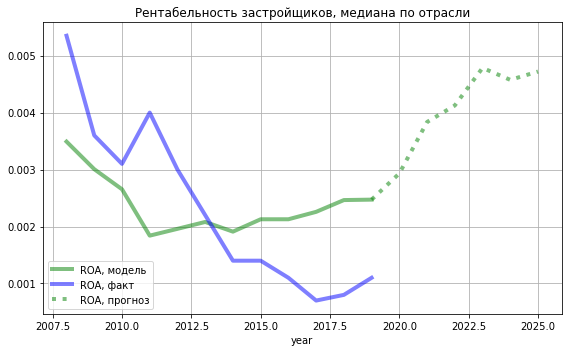

In [34]:
ax_roa=Ym_roa.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Рентабельность застройщиков, медиана по отрасли', color='g')

X_roa.rename(columns={'ROA':'ROA, факт'})[['ROA, факт']].plot.line(ax=ax_roa, color='b', linewidth=4, alpha=0.5)
y_roa.plot.line(ax=ax_roa, color='g', style=':', linewidth=4, alpha=0.5, grid=True)

# pdfSubModResult.dropna().plot.line(ax=ax_roa, style='.-', color='maroon', linewidth=14, alpha=0.2)
plt.tight_layout()
plt.show();

## Модель *Чистая кредиторская задолженность (по модулю), медиана по отрасли (Z_A)*
<br>
<center>$\overline{Z\_A}$ ~ $I\_phyvol\_issue_{y-1} + Chng\_avrg\_num\_empls_{y-1} + 1$</center>
<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Индекс физобъема выпуска (<i>I_phyvol_issue</i>, из данных Долгосрочной модели, с лагом 1 год)</li>
        <li>Изменение среднесписочной численности работников (<i>Chng_avrg_num_empls</i>, из данных Долгосрочной модели, с лагом 1 год))</li>        
    </ul><br>
    <b>Объясняемая переменная</b> - медианная по отрасли Чистая кредиторская задолженность (<i>Z_A</i> датафрейма <i>pdfSPARK</i>)
</div>

In [61]:
pdfZ_A=pdfSPARK.groupby(by='year').agg({'Z_A':np.median})
X_za, x_za=prep_XY(pdfXx=pdfModel, lstXFieldNames=['I_phyvol_issue', 'Chng_avrg_num_empls'], pdfY=pdfZ_A)

resZ_A = smf.ols(formula="Z_A ~ I_phyvol_issue.shift(1) + Chng_avrg_num_empls.shift(1)", 
                 missing='drop', data=X_za).fit()

print(resZ_A.summary())

                            OLS Regression Results                            
Dep. Variable:                    Z_A   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.247
Date:                Wed, 23 Dec 2020   Prob (F-statistic):              0.338
Time:                        19:24:10   Log-Likelihood:                 39.588
No. Observations:                  11   AIC:                            -73.18
Df Residuals:                       8   BIC:                            -71.98
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [62]:
Ym_za=pd.DataFrame(resZ_A.predict(X_za), index=X_za.index, columns=['Z_A, модель'])
y_za=pd.DataFrame(resZ_A.predict(x_za), columns=['Z_A, прогноз'])[:-1]

# формируем датафрейм с данными для основной модели - модели банкротств (ПОРЯДОК ВЫПОЛНЕНИЯ ВАЖЕН!!!)
pdfSubModResult.loc[y_za.index, 'Z_A_']=y_za.iloc[:, 0]
pdfSubModResult.loc[X_za.index, 'Z_A_']=X_za.iloc[:, 0]
# pdfSubModResult

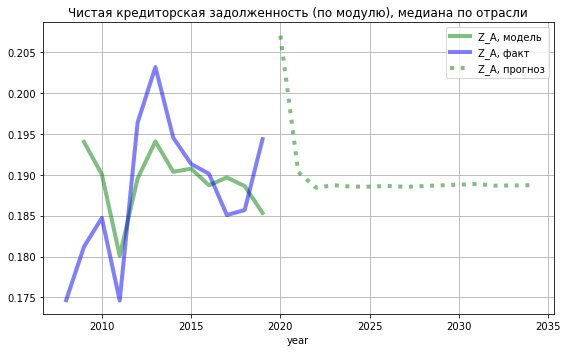

In [63]:
ax_za=Ym_za.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Чистая кредиторская задолженность (по модулю), медиана по отрасли', color='g')
X_za.rename(columns={'Z_A':'Z_A, факт'})[['Z_A, факт']].plot.line(ax=ax_za, color='b', linewidth=4, alpha=0.5)
y_za.plot.line(ax=ax_za, color='g', style=':', linewidth=4, alpha=0.5, grid=True)

# pdfSubModResult['Z_A_'].dropna().plot.line(ax=ax_za, color='grey', linewidth=14, alpha=0.3)

plt.tight_layout()
plt.show();

## Модель *Ставка по кредитам*

### Читаем данные из рабочей базы

Данные из таблицы LOAN читаются запросом loan_agg. Расчеты выполняются в блокноте.   
Данные из таблиц LENDING и LANDING_RESERV читаем из таблиц напрямую, расчеты в блокноте

### Читаем таблицу loan и считаем среднюю кредитную ставку за год (Y)

In [447]:
strSELECT_LOAN='select * from {loan_table}'.format(loan_table=strLOAN_agg)

pdfLOAN=pd.read_sql(strSELECT_LOAN, con=conWork)

pdfLOAN['date']=pd.to_datetime(pdfLOAN['date'], format='%Y-%m-%d')
pdfLOAN['loan_nonfin']=pdfLOAN['loan_nonfin'].astype(float)

pdfLOAN=pdfLOAN.set_index('date').groupby(by=pd.Grouper(freq='Y'))['loan_nonfin'].mean()
pdfLOAN.index=pdfLOAN.index.year
pdfLOAN.name='LOAN'
pdfLOAN

date
2011     8.450000
2012     9.100000
2013     9.466667
2014    11.135000
2015    15.716667
2016    12.592500
2017    10.560000
2018     8.866667
2019     8.753333
2020     7.011111
Name: LOAN, dtype: float64

### Средний фактический уровень РВПС по ссудам I-IV категорий качества, в % от ссудной задолженности (RVPS)

Расчеты выполняются в блокноте:
- по таблице lending считем доли Нестандаpтных, Сомнительных, Проблемных и Безнадежных ссуд **БЕЗ** Стандартных -$nonstandart + doubtful + problem + hopeless = 100\%$ для всех январей.
- перемножаем на соотв. показатель таблицы landing_reserv - $landing.nonstandart * landing\_reserv.nonstandart$
- считаем показатель кредитного риска - 
$\sum(landing*landing\_reserv)$ Поскольку берем данные по январям для каждого года, окончательное число это показатель предидущего - реиндексируем по `год-1`


In [448]:
strSELECT_LEND_PRC='select date, nonstandart, doubtful, problem, hopeless from {lend_prc_table}'.format(lend_prc_table=strLEND_PRC_table)
strSELECT_LEND_RES='select date, nonstandart, doubtful, problem, hopeless from {lend_res_table}'.format(lend_res_table=strLEND_RES_table)

pdfLEND_PRC=pd.read_sql(strSELECT_LEND_PRC, con=conWork, parse_dates={'date':'%d.%m.%y'}, index_col='date').sort_index()
pdfLEND_RES=pd.read_sql(strSELECT_LEND_RES, con=conWork, parse_dates={'date':'%d.%m.%y'}, index_col='date').sort_index()

# берем только январи для каждого года
pdfLEND_PRC=pdfLEND_PRC[pdfLEND_PRC.index.month==1]
pdfLEND_RES=pdfLEND_RES[pdfLEND_RES.index.month==1]

pdf_RVPS=pdfLEND_RES.mul(pdfLEND_PRC.div(pdfLEND_PRC.sum(axis=1), axis=0), axis=0).sum(axis=1).groupby(by=pd.Grouper(freq='YS')).mean()

# новый индекс: сдвиг по году year-1
pdf_RVPS.index=pdf_RVPS.index.year-1
pdf_RVPS.name='rvps'
pdf_RVPS

date
2010    16.085478
2011    15.490558
2012    11.685299
2013    10.744737
2014    12.613371
2015    14.052372
2016    14.883957
2017    17.076457
2018    16.561299
2019    15.513822
Name: rvps, dtype: float64

### Готовим данные и оцениваем модель

- Делаем полный фрейм `x` модели (X и x вместе, факт + прогнозный период)

- Корректируем `key_rate` значениями `rvps`:   $RATE\_CORRECT = \frac {(key\_rate \cdot 100) \cdot rvps}{100}$ 

- Переводим значения ИПЦ:   $ CPI_{corr} = (CPI-1) \cdot 100 $

- Оцениваем модель

<br>
<center>$\overline{LOAN}$ ~ $CPI_{corr} + RATE\_CORRECT$</center>
<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Ключевая ставка (с середины 2013 г.; до середины 2013 года - ставка РЕПО), скорректированная на `Средний фактический уровень РВПС по ссудам I-IV категорий качества, в % от ссудной задолженности (<i>RATE_CORRECT</i>)</li>        
        <li>ИПЦ, в среднем за год (<i>CPI</i>)</li>
    </ul><br>
    <b>Объясняемая переменная</b> - Средневзвешенная ставка по рублевым кредитам предприятиям (<i>loan</i> датафрейма <i>pdfLOAN</i>)
</div>

In [449]:
pdfLoanXx=pdfModel[['CPI', 'key_rate']].dropna().join(pdf_RVPS).ffill().dropna()

pdfLoanXx['rate_correct']=(pdfLoanXx['key_rate']*100*pdfLoanXx['rvps'])/100
pdfLoanXx['CPI']=(pdfLoanXx['CPI']-1)*100

X_loan, x_loan=prep_XY(pdfXx=pdfLoanXx, 
                   lstXFieldNames=['CPI', 'rate_correct', 'key_rate', 'rvps'], pdfY=pd.DataFrame(pdfLOAN))

resLOAN = smf.ols(formula="LOAN ~ CPI +  rate_correct - 1", 
                 missing='drop', data=X_loan).fit()

# resLOAN = smf.ols(formula="LOAN ~ CPI + (key_rate*rvps)  - 1", 
#                  missing='drop', data=X_loan).fit()

print(resLOAN.summary())

                                 OLS Regression Results                                
Dep. Variable:                   LOAN   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              218.5
Date:                Fri, 18 Dec 2020   Prob (F-statistic):                    1.04e-07
Time:                        19:57:21   Log-Likelihood:                         -17.550
No. Observations:                  10   AIC:                                      39.10
Df Residuals:                       8   BIC:                                      39.70
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [450]:
Ym_loan=pd.DataFrame(resLOAN.predict(X_loan), index=X_loan.index, columns=['LOAN, модель'])
y_loan=pd.DataFrame(resLOAN.predict(x_loan), columns=['LOAN, прогноз'])[:-1]

# формируем датафрейм с данными для основной модели - модели банкротств (ПОРЯДОК ВЫПОЛНЕНИЯ ВАЖЕН!!!)
pdfSubModResult.loc[y_loan.index, 'LOAN_']=y_loan.iloc[:, 0]
pdfSubModResult.loc[X_loan.index, 'LOAN_']=X_loan.iloc[:, 0]

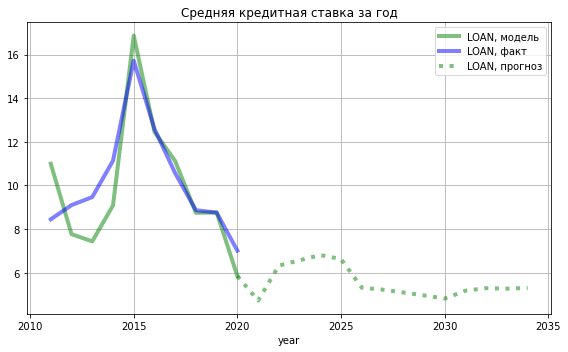

In [451]:
ax_loan=Ym_loan.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Средняя кредитная ставка за год', color='g')
X_loan.rename(columns={'LOAN':'LOAN, факт'})[['LOAN, факт']].plot.line(ax=ax_loan, color='b', linewidth=4, alpha=0.5)
y_loan.plot.line(ax=ax_loan, color='g', style=':', linewidth=4, alpha=0.5, grid=True)

plt.tight_layout()
plt.show();

# Подготовка данных для основной модели

Для моделирования банкротств предприятий (основная модель) используются следующие поля:  
  - ROA (рентабельность, моделируется)
  - Z_A (чистая кредиторская задолженность, моделируется)
  - LOAN (моделируется)
  - capital (уставной капитал, из базы данных SPARK)
  - Y - фактические банкротства, флаг. Y=1 означает, что в этом году предприятие обанкротилось (данные из рабочей базы, таблица strBNKRPT_table).   
  
Все данные индексируются по компаниям (поле inn) и по годам (поле year). 

<div class="alert alert-block alert-info">
    <b>Алгоритм:</b>
    <ul>
        <li>Для каждой компании необходимо продлить предикторы на прогнозный период. Для этого используем данные промежуточного моделирования: медианные рентабельность и задолженость.</li>
        <li>Считаем прирост рентабельности и задолженности за год, полученными приростами "раскручиваем" соответствующие поля каждой компании (кумулятивной суммой). </li>
        <li>В поле `capital`заполняем пропуски по годам ближайшими значениями (вперед и назад).</li>
        <li>Устанавливаем `Y` - флаг банкротства - из таблицы фактических банкротств компаний. Данные для сделующих годов компаний с установленным флагом удаляются - компания прекратила существование.</li>                
    </ul><br>
    Полученный фрейм сохраняем в базе данных для последующего использования в основной модели.
</div>


### Подготовка данных - результатов промежуточных моделей

Считаем темпы и прирост медианных ROA, Z_A и LOAN. Суффиксы данных:  
  - '_' - медианое (модельное) значение
  - '_t' - темпы (`pct_change`)
  - '_d' - прирост (`diff`)

$ ROA\_d_i = \overline{ROA_i}-\overline{ROA_{i-1}}; \qquad ROA\_t_i = \dfrac {\overline{ROA_i}-\overline{ROA_{i-1}}} { \overline{ROA_{i-1}} }  $  


$ Z\_A\_d_i = \overline{Z\_A_i}-\overline{Z\_A_{i-1}}; \qquad Z\_A\_t_i = \dfrac { \overline{Z\_A_i}-\overline{Z\_A_{i-1}} } { \overline{Z\_A_{i-1}} }  $  

В дальнейшем используется прирост, однако темпы считаются на всякий случай 

Поля с `np.nan` в моделировании не участвуют, поэтому обрезаем базу данных SPARK снизу по последнему валидному году (`iMinYear`) во фрейме с модельными данными (modelResult).  

In [479]:
pdf_res = pdfSubModResult.copy()
pdf_res=pdf_res.join(pdf_res.pct_change(), rsuffix='t') # считаем темпы
pdf_res=pdf_res.join(pdf_res[['ROA_', 'Z_A_', 'LOAN_']].diff(), rsuffix='d') # считаем прирост
pdf_res=pdf_res.dropna() # удаляем отсутствующие даные
iMinYear=pdf_res.index.min()
pdf_res
# %store pdf_res

,ROA_,Z_A_,LOAN_,ROA_t,Z_A_t,LOAN_t,ROA_d,Z_A_d,LOAN_d
year,,,,,,,,,
2012,0.003000,0.196358,9.100000,-0.250000,0.124454,0.076923,-0.001000,0.021733,0.650000
2013,0.002200,0.203161,9.466667,-0.266667,0.034648,0.040293,-0.000800,0.006803,0.366667
2014,0.001400,0.194526,11.135000,-0.363636,-0.042504,0.176232,-0.000800,-0.008635,1.668333
2015,0.001400,0.191316,15.716667,0.000000,-0.016500,0.411465,0.000000,-0.003210,4.581667
2016,0.001100,0.190117,12.592500,-0.214286,-0.006267,-0.198780,-0.000300,-0.001199,-3.124167
2017,0.000700,0.185076,10.560000,-0.363636,-0.026518,-0.161406,-0.000400,-0.005042,-2.032500
2018,0.000800,0.185689,8.866667,0.142857,0.003315,-0.160354,0.000100,0.000614,-1.693333
2019,0.002490,0.194353,8.753333,2.112667,0.046656,-0.012782,0.001690,0.008663,-0.113333
2020,0.002941,0.207002,7.011111,0.181230,0.065081,-0.199035,0.000451,0.012649,-1.742222


### Соединение таблицы SPARK и таблицы с результатами промежуточного моделирования.

Из базы данных SPARK удаляем все строки, в которых нет либо ROA, либо Z_A данных. Дальнейшее моделирования будет происходить именно по этим данных.  

In [480]:
pdf_sp=pdfSPARK.loc[pdfSPARK[['ROA', 'Z_A']].dropna(how='any').index].copy()
pdf_sp=pdf_sp.sort_values(by=['inn', 'year'])
pdf_sp=pdf_sp[pdf_sp['year']>=iMinYear].set_index(['inn', 'year']) # переходим на мультииндекс

pdf_sp

capital Cancel_date     ROA       Z_A
inn        year                                          
0104014512 2014     10000.0         NaT -0.0426  0.797872
           2015     10000.0         NaT  0.0041  0.960739
           2016     10000.0         NaT  0.0015  0.255651
           2017  40000000.0         NaT  0.0523  0.190691
           2018  40000000.0         NaT  0.0011  0.178391
...                     ...         ...     ...       ...
9731012872 2013     10000.0  2019-05-08  0.0464  0.037122
           2014     10000.0  2019-05-08  0.0263  0.000756
           2015     10000.0  2019-05-08 -0.0277  0.374827
           2016     10000.0  2019-05-08  0.0002  0.301840
9909127226 2017         NaN         NaT  0.4867  0.356039

[39703 rows x 4 columns]

#### Соединяем фреймы SPARK и результаты моделирования в один
Медианные (модельные) данные копируются для каждой компании (одинаковы для всех компаний)

In [481]:
i_new=[ (c, i) for c in pdf_sp.columns for i in pdf_res.index]

pdf_sp=pdf_sp.unstack().reindex(columns=i_new).stack(dropna=False)

pdf_sp=pdf_sp.join(pdf_res, on='year')
pdf_sp.loc[idx[ ['9909127226', '0104014512'], :], :]

Cancel_date     ROA       Z_A     capital      ROA_      Z_A_  \
inn        year                                                                 
9909127226 2012         NaT     NaN       NaN         NaN  0.003000  0.196358   
           2013         NaT     NaN       NaN         NaN  0.002200  0.203161   
           2014         NaT     NaN       NaN         NaN  0.001400  0.194526   
           2015         NaT     NaN       NaN         NaN  0.001400  0.191316   
           2016         NaT     NaN       NaN         NaN  0.001100  0.190117   
           2017         NaT  0.4867  0.356039         NaN  0.000700  0.185076   
           2018         NaT     NaN       NaN         NaN  0.000800  0.185689   
           2019         NaT     NaN       NaN         NaN  0.002490  0.194353   
           2020         NaT     NaN       NaN         NaN  0.002941  0.207002   
           2021         NaT     NaN       NaN         NaN  0.005940  0.190325   
           2022         NaT     NaN       NaN         NaN  0.004892  0.188416   
           2023         NaT     NaN       NaN         NaN  0.006084  0.188716   
           2024         NaT     NaN       NaN         NaN  0.005348  0.188548   
           2025         NaT     NaN       NaN         NaN  0.005477  0.188548   
0104014512 2012         NaT     NaN       NaN         NaN  0.003000  0.196358   
           2013         NaT     NaN       NaN         NaN  0.002200  0.203161   
           2014         NaT -0.0426  0.797872     10000.0  0.001400  0.194526   
           2015         NaT  0.0041  0.960739     10000.0  0.001400  0.191316   
           2016         NaT  0.0015  0.255651     10000.0  0.001100  0.190117   
           2017         NaT  0.0523  0.190691  40000000.0  0.000700  0.185076   
           2018         NaT  0.0011  0.178391  40000000.0  0.000800  0.185689   
           2019         NaT  0.0006  0.082383   2495000.0  0.002490  0.194353   
           2020         NaT     NaN       NaN         NaN  0.002941  0.207002   
           2021         NaT     NaN       NaN         NaN  0.005940  0.190325   
           2022         NaT     NaN       NaN         NaN  0.004892  0.188416   
           2023         NaT     NaN       NaN         NaN  0.006084  0.188716   
           2024         NaT     NaN       NaN         NaN  0.005348  0.188548   
           2025         NaT     NaN       NaN         NaN  0.005477  0.188548   

                     LOAN_     ROA_t     Z_A_t    LOAN_t     ROA_d     Z_A_d  \
inn        year                                                                
9909127226 2012   9.100000 -0.250000  0.124454  0.076923 -0.001000  0.021733   
           2013   9.466667 -0.266667  0.034648  0.040293 -0.000800  0.006803   
           2014  11.135000 -0.363636 -0.042504  0.176232 -0.000800 -0.008635   
           2015  15.716667  0.000000 -0.016500  0.411465  0.000000 -0.003210   
           2016  12.592500 -0.214286 -0.006267 -0.198780 -0.000300 -0.001199   
           2017  10.560000 -0.363636 -0.026518 -0.161406 -0.000400 -0.005042   
           2018   8.866667  0.142857  0.003315 -0.160354  0.000100  0.000614   
           2019   8.753333  2.112667  0.046656 -0.012782  0.001690  0.008663   
           2020   7.011111  0.181230  0.065081 -0.199035  0.000451  0.012649   
           2021   4.725591  1.019392 -0.080561 -0.325985  0.002998 -0.016676   
           2022   6.327573 -0.176394 -0.010032  0.339002 -0.001048 -0.001909   
           2023   6.569880  0.243634  0.001596  0.038294  0.001192  0.000301   
           2024   6.812186 -0.120958 -0.000891  0.036881 -0.000736 -0.000168   
           2025   6.626160  0.024090  0.000000 -0.027308  0.000129  0.000000   
0104014512 2012   9.100000 -0.250000  0.124454  0.076923 -0.001000  0.021733   
           2013   9.466667 -0.266667  0.034648  0.040293 -0.000800  0.006803   
           2014  11.135000 -0.363636 -0.042504  0.176232 -0.000800 -0.008635   
           2015  15.716667  0.000000 -0.016500  0.411465  0.00000

#### Поле capital
Поле `capital` растягиваем по всем данным компании (уставной капитал меняется редко, но в разных годах по компании, часто не указывается, видимо, ошибка в данных). Растягиваем известное значение как вперед по годам, так и назад, удаляем фирмы без capital (с capital полностью nan)

In [482]:
pdf_sp['capital']=pdf_sp.groupby(level=0)['capital'].ffill().bfill()
pdf_sp

Cancel_date     ROA       Z_A  capital      ROA_      Z_A_  \
inn        year                                                              
0104014512 2012         NaT     NaN       NaN  10000.0  0.003000  0.196358   
           2013         NaT     NaN       NaN  10000.0  0.002200  0.203161   
           2014         NaT -0.0426  0.797872  10000.0  0.001400  0.194526   
           2015         NaT  0.0041  0.960739  10000.0  0.001400  0.191316   
           2016         NaT  0.0015  0.255651  10000.0  0.001100  0.190117   
...                     ...     ...       ...      ...       ...       ...   
9909127226 2021         NaT     NaN       NaN      NaN  0.005940  0.190325   
           2022         NaT     NaN       NaN      NaN  0.004892  0.188416   
           2023         NaT     NaN       NaN      NaN  0.006084  0.188716   
           2024         NaT     NaN       NaN      NaN  0.005348  0.188548   
           2025         NaT     NaN       NaN      NaN  0.005477  0.188548   

                     LOAN_     ROA_t     Z_A_t    LOAN_t     ROA_d     Z_A_d  \
inn        year                                                                
0104014512 2012   9.100000 -0.250000  0.124454  0.076923 -0.001000  0.021733   
           2013   9.466667 -0.266667  0.034648  0.040293 -0.000800  0.006803   
           2014  11.135000 -0.363636 -0.042504  0.176232 -0.000800 -0.008635   
           2015  15.716667  0.000000 -0.016500  0.411465  0.000000 -0.003210   
           2016  12.592500 -0.214286 -0.006267 -0.198780 -0.000300 -0.001199   
...                    ...       ...       ...       ...       ...       ...   
9909127226 2021   4.725591  1.019392 -0.080561 -0.325985  0.002998 -0.016676   
           2022   6.327573 -0.176394 -0.010032  0.339002 -0.001048 -0.001909   
           2023   6.569880  0.243634  0.001596  0.038294  0.001192  0.000301   
           2024   6.812186 -0.120958 -0.000891  0.036881 -0.000736 -0.000168   
           2025   6.626160  0.024090  0.000000 -0.027308  0.000129  0.000000   

                   LOAN_d  
inn        year            
0104014512 2012  0.650000  
           2013  0.366667  
           2014  1.668333  
           2015  4.581667  
           2016 -3.124167  
...                   ...  
9909127226 2021 -2.285520  
           2022  1.601983  
           2023  0.242306  
           2024  0.242306  
           2025 -0.186027  

[112770 rows x 13 columns]

In [483]:
# следующая строчка нужна для отработки (тестирования) фрейма в другом блокноте - при необходимости раскомментировать

# %store pdf_sp

### Продление полей на прогнозный период

Теперь надо продлить **для каждой фирмы** ROA и Z_A на прогнозные годы, используя прирост медианной ROA и Z_A из фрейма с результатами промежуточного моделирования.

Для компаний-банкротов (установленный флаг Y) удаляются все данные по годам после факта банкротства.

Заводим новые поля с суффиксом '_par' - parameters - эти поля будут результатами, в них будут данные для основной модели.  
В поля '_par' записываем: все существующие значения полей ROA, Z_A. Прогнозные годы заполняем значениями полей с суффиксами '_d' - приростами медианных значений. От последнего фактического значения **по каждой компании** (группировка по компаниям)  выполняем `cumsum` - кумулятивную сумму по полям '_par'. 
Таким образом первым элементом кумулятивной суммы будет последнее фактическое значение, на каждом последющем годе к нему будет прибавлятся прирост медианного значения соотв. параметра.

$
\begin{equation*}
ROA\_par_i =  
 \begin{cases}
   ROA_i &\text{i <= последний фактический год }\\
   ROA\_d_i + ROA\_par_{i-1} &\text{i >= первый прогнозный год}
 \end{cases}
\end{equation*}
$


$
\begin{equation*}
Z\_A\_par_i =  
 \begin{cases}
   Z\_A_i &\text{i <= последний фактический год }\\
   Z\_A\_d_i + Z\_A\_par_{i-1} &\text{i >= первый прогнозный год}
 \end{cases}
\end{equation*}
$

$
\begin{equation*}
LOAN\_par_i =  
 \begin{cases}
   LOAN_i &\text{i <= последний фактический год }\\
   LOAN\__i &\text{i >= первый прогнозный год, LOAN_ - модельное значение ставки}
 \end{cases}
\end{equation*}
$

In [484]:
lstInn=['0107030022', '0107030777', '0225010632'] # фильтр по компаниям - для удобства контроля, для минимизации вывода

iForeYear=2020 # первый прогнозный год - можгно поменять
iLastYear=pdf_sp.index.get_level_values('year').unique().tolist()[-1] # последний прогнозный год - из фрейма

lstCalcPars=['ROA_par', 'Z_A_par'] # поля параметров - итоговые поля для записи в базу данных
lstSrcPars=['ROA', 'Z_A'] # фактические поля, из базы данных SPARK
lstAddPars=['ROA_d', 'Z_A_d'] # поля с расчитанными приростами

lstForeYears=list(range(iForeYear, iLastYear+1)) # список прогнозных годов
lstWorkYears=[iForeYear-1, ] + lstForeYears # список прогнозных годов с последним фактическим

pdf_sp[lstCalcPars]=pdf_sp[lstSrcPars] # записываем фактические значения в окончательные (прогнозные года будут пустыми)

idx = pd.IndexSlice

# записываем в прогнозные года значения приростов для последующей кумулятивной суммы
pdf_sp.loc[idx[:, lstForeYears], idx[lstCalcPars]]=pdf_sp.loc[idx[:, lstForeYears], idx[lstAddPars]].values

# в параметрических полях считаем кумулятивную сумму по прогнозным годам с группировкой по компаниям (индекс inn, level = 0)
pdf_sp.loc[idx[:, lstForeYears], idx[lstCalcPars]]=pdf_sp.loc[idx[:, lstWorkYears], idx[lstCalcPars]].groupby(level=0)[lstCalcPars].cumsum()
pdf_sp=pdf_sp.rename(columns={'LOAN_':'LOAN_par'})
pdf_sp.loc[idx[lstInn, :], idx[:]]

Cancel_date     ROA       Z_A    capital      ROA_      Z_A_  \
inn        year                                                                
0107030022 2012         NaT     NaN       NaN    10000.0  0.003000  0.196358   
           2013         NaT     NaN       NaN    10000.0  0.002200  0.203161   
           2014         NaT     NaN       NaN    10000.0  0.001400  0.194526   
           2015         NaT     NaN       NaN    10000.0  0.001400  0.191316   
           2016         NaT     NaN       NaN    10000.0  0.001100  0.190117   
           2017         NaT -0.0236  0.599237    10000.0  0.000700  0.185076   
           2018         NaT     NaN       NaN    10000.0  0.000800  0.185689   
           2019         NaT  0.1437  0.042766    20000.0  0.002490  0.194353   
           2020         NaT     NaN       NaN    20000.0  0.002941  0.207002   
           2021         NaT     NaN       NaN    20000.0  0.005940  0.190325   
           2022         NaT     NaN       NaN    20000.0  0.004892  0.188416   
           2023         NaT     NaN       NaN    20000.0  0.006084  0.188716   
           2024         NaT     NaN       NaN    20000.0  0.005348  0.188548   
           2025         NaT     NaN       NaN    20000.0  0.005477  0.188548   
0107030777 2012         NaT     NaN       NaN    10000.0  0.003000  0.196358   
           2013         NaT     NaN       NaN    10000.0  0.002200  0.203161   
           2014         NaT     NaN       NaN    10000.0  0.001400  0.194526   
           2015         NaT     NaN       NaN    10000.0  0.001400  0.191316   
           2016         NaT -1.5000  0.392857    10000.0  0.001100  0.190117   
           2017         NaT -0.9643  1.107143    10000.0  0.000700  0.185076   
           2018         NaT -0.0473  0.097931    10000.0  0.000800  0.185689   
           2019         NaT  0.0465  0.107868    10000.0  0.002490  0.194353   
           2020         NaT     NaN       NaN    10000.0  0.002941  0.207002   
           2021         NaT     NaN       NaN    10000.0  0.005940  0.190325   
           2022         NaT     NaN       NaN    10000.0  0.004892  0.188416   
           2023         NaT     NaN       NaN    10000.0  0.006084  0.188716   
           2024         NaT     NaN       NaN    10000.0  0.005348  0.188548   
           2025         NaT     NaN       NaN    10000.0  0.005477  0.188548   
0225010632 2012         NaT  0.0236  0.751464  1300000.0  0.003000  0.196358   
           2013         NaT  0.0793  0.768345  1300000.0  0.002200  0.203161   
           2014         NaT  0.0565  0.569405  1300000.0  0.001400  0.194526   
           2015         NaT -0.0491  0.609283  1300000.0  0.001400  0.191316   
           2016         NaT  0.0068  0.650701  1300000.0  0.001100  0.190117   
           2017         NaT  0.0351  0.320901  4456000.0  0.000700  0.185076   
           2018         NaT  0.0259  0.363531  4456000.0  0.000800  0.185689   
           2019         NaT  0.0082  0.222574  4456000.0  0.002490  0.194353   
           2020         NaT     NaN       NaN  4456000.0  0.002941  0.207002   
           2021         NaT     NaN       NaN  4456000.0  0.005940  0.190325   
           2022         NaT     NaN       NaN  4456000.0  0.004892  0.188416   
           2023         NaT     NaN       NaN  4456000.0  0.006084  0.188716   
           2024         NaT     NaN       NaN  4456000.0  0.005348  0.188548   
           2025         NaT     NaN       NaN  4456000.0  0.005477  0.188548   

                  LOAN_par     ROA_t     Z_A_t    LOAN_t     ROA_d     Z_A_d  \
inn        year                                                                
0107030022 2012   9.100000 -0.250000  0.124454  0.076923 -0.001000  0.021733   
           2013   9.466667 -0.266667  0.034648  0.040293 -0.000800  0.006803   
           2014  11.135000 -0.363636 -0.042504  0.176232 -0.000800 -0.008635   
           2015  15.716667  0.000000 -0.016500  0.411465  0.000000 -0.003210   
           2016

### Установка флага фактического банкротства компании. Читаем данные фактических банкротств (для всех компаний), выбираем из них только те компании, inn которых есть в базе SPARK

"1" в соотв. году означает банкростство даной компании в этом году. Данные последующих лет для этой компании удаляются (ниже).

In [486]:
strSELECT_Y='select * from {bnkrpt_table}'.format(bnkrpt_table=strBNKRPT_table)

pdf_bnkrpt=pd.read_sql(strSELECT_Y, con=conWork)
pdf_bnkrpt=pdf_bnkrpt.loc[pdf_bnkrpt['inn'].isin(pdfSPARK['inn'].unique())].set_index(['inn', 'year'])
pdf_bnkrpt

,,Y
inn,year,
1001178052,2019,1
1001197513,2020,1
1001224929,2018,1
1001253969,2018,1
1001278882,2020,1
...,...,...
8911001194,2016,1
8911017557,2020,1
9201013503,2018,1


In [499]:
pdf_sp.loc[pdf_sp.index.isin(pdf_bnkrpt.index), 'Y']=1
pdf_sp['Y'].fillna(0, inplace=True)
pdf_sp
pdf_sp[pdf_sp['Y']==1]

,,Cancel_date,ROA,Z_A,capital,ROA_,Z_A_,LOAN_par,ROA_t,Z_A_t,LOAN_t,ROA_d,Z_A_d,LOAN_d,ROA_par,Z_A_par,Y
inn,year,,,,,,,,,,,,,,,,
1001178052,2019,NaT,-0.0044,0.001583,10000.0,0.002490,0.194353,8.753333,2.112667,0.046656,-0.012782,0.001690,0.008663,-0.113333,-0.004400,0.001583,1.0
1001197513,2020,NaT,NaN,NaN,70000.0,0.002941,0.207002,7.011111,0.181230,0.065081,-0.199035,0.000451,0.012649,-1.742222,0.000451,0.012649,1.0
1001224929,2018,2019-10-07,0.0057,2.176518,10000.0,0.000800,0.185689,8.866667,0.142857,0.003315,-0.160354,0.000100,0.000614,-1.693333,0.005700,2.176518,1.0
1001253969,2018,NaT,NaN,NaN,15000.0,0.000800,0.185689,8.866667,0.142857,0.003315,-0.160354,0.000100,0.000614,-1.693333,NaN,NaN,1.0
1001278882,2020,NaT,NaN,NaN,10000.0,0.002941,0.207002,7.011111,0.181230,0.065081,-0.199035,0.000451,0.012649,-1.742222,0.000451,0.012649,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8909002828,2018,NaT,NaN,NaN,10000.0,0.000800,0.185689,8.866667,0.142857,0.003315,-0.160354,0.000100,0.000614,-1.693333,NaN,NaN,1.0
8911001194,2016,NaT,NaN,NaN,7609000.0,0.001100,0.190117,12.592500,-0.214286,-0.006267,-0.198780,-0.000300,-0.001199,-3.124167,NaN,NaN,1.0
8911017557,2020,NaT,NaN,NaN,10000.0,0.002941,0.207002,7.011111,0.181230,0.065081,-0.199035,0.000451,0.012649,-1.742222,0.000451,0.012649,1.0


### Очистка полученного фрейма
  - так как кумулятивные суммы считаются от последнего фактического года данные компаний, у которых нет значений для последнего фактического года удаляются (кумулятивный суммам не с чего стартовать, расчитанные данные бессмысленны)
  - данные компаний-фактических банкротов после банкротства бессмысленны - тоже удаляются

In [500]:
# выбираем значимые компании - у которых есть данные по последнему фактическому году

lstFinalFields=lstCalcPars + ['capital', 'Y', 'LOAN_par']
inn_valued=pdf_sp.loc[pdf_sp.loc[idx[:, iForeYear-1], idx[lstCalcPars]].dropna().index].index.get_level_values(0).unique().tolist()


pdf_sp=pdf_sp.loc[idx[inn_valued, :], idx[lstFinalFields]].dropna()
pdf_sp=pdf_sp.loc[pdf_sp[lstCalcPars].any(axis=1, skipna=True), idx[lstFinalFields]]
pdf_sp

ROA_par   Z_A_par       capital    Y   LOAN_par
inn        year                                                  
0104014512 2014 -0.042600  0.797872  1.000000e+04  0.0  11.135000
           2015  0.004100  0.960739  1.000000e+04  0.0  15.716667
           2016  0.001500  0.255651  1.000000e+04  0.0  12.592500
           2017  0.052300  0.190691  4.000000e+07  0.0  10.560000
           2018  0.001100  0.178391  4.000000e+07  0.0   8.866667
...                   ...       ...           ...  ...        ...
9729055420 2021  0.002250  0.033804  4.000020e+09  0.0   4.725591
           2022  0.001202  0.031894  4.000020e+09  0.0   6.327573
           2023  0.002394  0.032195  4.000020e+09  0.0   6.569880
           2024  0.001658  0.032027  4.000020e+09  0.0   6.812186
           2025  0.001787  0.032027  4.000020e+09  0.0   6.626160

[60509 rows x 5 columns]

<div class="alert alert-block alert-warning">
    <b>Выполнение следующей ячейки занимает много времени</b>
</div>

In [501]:
# удаляем данные компаний-банкротов ПОСЛЕ года фактического банкротства
pdf_drop=pd.concat([pdf_sp.query('inn=="{inn}" & year > {year}'.format(inn=ind[0], year=ind[1])) for ind in pdf_sp[pdf_sp['Y']==1].index.tolist()] )
pdf_sp.drop(index=pdf_drop.index, inplace=True)
pdf_sp

ROA_par   Z_A_par       capital    Y   LOAN_par
inn        year                                                  
0104014512 2014 -0.042600  0.797872  1.000000e+04  0.0  11.135000
           2015  0.004100  0.960739  1.000000e+04  0.0  15.716667
           2016  0.001500  0.255651  1.000000e+04  0.0  12.592500
           2017  0.052300  0.190691  4.000000e+07  0.0  10.560000
           2018  0.001100  0.178391  4.000000e+07  0.0   8.866667
...                   ...       ...           ...  ...        ...
9729055420 2021  0.002250  0.033804  4.000020e+09  0.0   4.725591
           2022  0.001202  0.031894  4.000020e+09  0.0   6.327573
           2023  0.002394  0.032195  4.000020e+09  0.0   6.569880
           2024  0.001658  0.032027  4.000020e+09  0.0   6.812186
           2025  0.001787  0.032027  4.000020e+09  0.0   6.626160

[59251 rows x 5 columns]

## Запись полученного фрейма в базу данных

Таблица `model_data`

*Для записи используется стандартный фрейм pandas, таблица перезаписывается полностью - она является результатом обработки, все года пересчитываются.*

Рабочие поля таблицы:
  - inn (индексное поле) - ИНН компании
  - year (индексное поле) - год снятия показателя. Годы после объявления компании банкротом отсутствуют
  - ROA_par - рентабельность, продленная на прогнозный период
  - Z_A_par - задолженность, продленная на прогнозный период
  - Y - флаг банкротства. "1" стоит в последнем валидном годе компании 

In [503]:
pdf_sp[lstFinalFields].to_sql(strModeLDATA_table, con=conWork, if_exists='replace')

_=conWork.execute('''INSERT OR REPLACE INTO {tab_info}(utable, udate) VALUES
('{table_name}', '{update_date}') '''.format(tab_info=strInfoTable, 
                                          update_date=dt.datetime.now().strftime('%Y-%m-%d'), table_name=strModeLDATA_table))

print('Done for', pdf_sp.shape)

Done for (59251, 5)


## Окончание работы - сжатие и очиста базы даных

In [504]:
import sqlite3
conn = sqlite3.connect(strDB_path, isolation_level=None)
conn.execute("VACUUM") # сжатие базы данных
conn.close()

print('All done')

All done
